In [1]:
import pandas  as pd
import numpy as np
import os
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, Flatten, Input,MaxPooling1D,Dense, Dropout ,Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import LSTM
from keras.models import Model
from sklearn.metrics import roc_auc_score , accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import wordnet 
import random

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_data = pd.read_csv(r'data.csv')

In [3]:
df_data.head()

,id,title,author,text,label
0,12159,Trump Has Gotten The Republican Party Sued For...,Jason Easley,The Washington Post reported : \nThe Democrati...,1
1,11921,Hand-Foot-And-Mouth Disease On The Rise: What ...,Dikran Arakelian (noreply@blogger.com),Share on Facebook Every parents worries about ...,1
2,17066,Show biz: Business and breakthroughs,Vanessa Frank,Show biz: Business and breakthroughs Exclusive...,1
3,728,How Voting Machines Are Programmed In Order To...,pcr3,How Voting Machines Are Programmed In Order To...,1
4,6058,Iranians arrested after celebrating ancient Pe...,Kaitlyn Stegall,"November 1, 2016 Iranians arrested after celeb...",1


Z dátovej množiny vyberieme len nami potrebné atribúty, teda text spravodajských článkov a ich hodnotenie teda label. 

In [4]:
df_data=df_data[['text', 'label']]

In [5]:
df_data.isnull().values.any()    # kontrola null hodnot

True

In [6]:
df_data.isnull().sum()

text     1
label    0
dtype: int64

In [7]:
df_data=df_data[df_data['text'].notnull()]
df_data["text"]=df_data["text"].str.strip()
df_data.text.replace('', np.NaN, inplace=True)###nahradenie prazdneho riadka hodnotou NAN
np.sum(df_data.isnull().any(axis=1))
df_data[df_data.isnull().any(axis=1)].head()
df_data.dropna(inplace=True)  ###odstraneie riadkov NaN
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7598 non-null   object
 1   label   7598 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 178.1+ KB


In [8]:
df_data.isnull().values.any()  


False

In [9]:
print(df_data.head())

                                                text  label
0  The Washington Post reported : \nThe Democrati...      1
1  Share on Facebook Every parents worries about ...      1
2  Show biz: Business and breakthroughs Exclusive...      1
3  How Voting Machines Are Programmed In Order To...      1
4  November 1, 2016 Iranians arrested after celeb...      1


In [10]:
df_data.label.value_counts()

0    7000
1     598
Name: label, dtype: int64

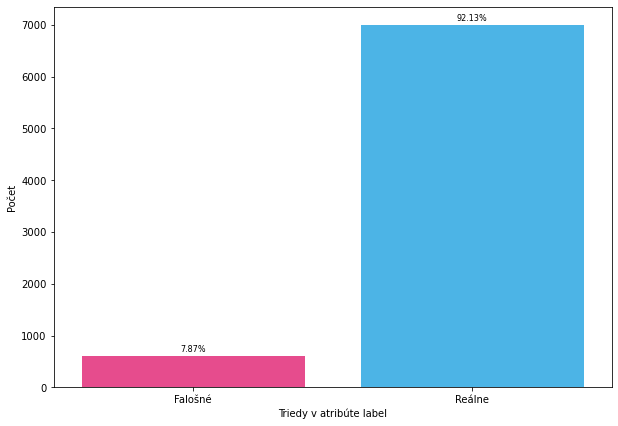

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
plot = sns.countplot(x='label', data=pd.DataFrame(df_data['label'].map({False:'Reálne',True:'Falošné'}), columns=['label']),palette=["#FF3389", "#33BDFF"])

ax = plot.axes
ax.set(xlabel="Triedy v atribúte label", ylabel = "Počet")


for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / df_data.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')




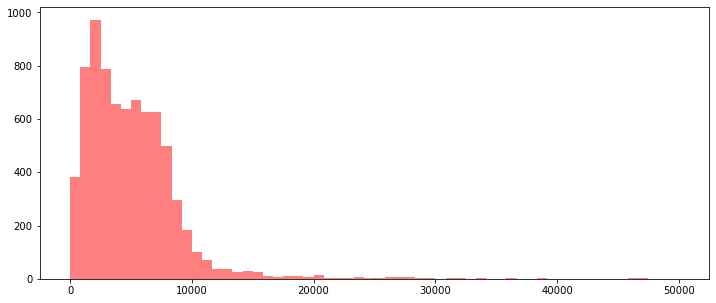

In [12]:
data_length = df_data.text.apply(len)
data_length.head()
plt.figure(figsize = (12, 5))
plt.hist(data_length, bins = 60, range = [0, 50000], alpha = 0.5, color = 'r')
plt.show()

In [13]:
df_data.label.value_counts()
x = df_data['text'].fillna("fillna")
y = df_data['label'].values

SEED = 42
x_train,x_test, y_train ,y_test= train_test_split(x, y, test_size=0.2, random_state=SEED)
print ("Celkový počet trénovacch príkladov je {0} z toho  {1:.2f}% je reálnych a {2:.2f}% je faločných".format(len(x_train),
                      (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))

print ("Celkový počet testovacich príkladov je {0} z toho {1:.2f}% je reálnych a {2:.2f}% je falošných".format(len(x_test),
                      (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Celkový počet trénovacch príkladov je 6078 z toho  92.43% je reálnych a 7.57% je faločných
Celkový počet testovacich príkladov je 1520 z toho 90.92% je reálnych a 9.08% je falošných


In [14]:
EMBEDDING_DIM = 300 
max_features = 50000 
max_length = 2500 

print("Načítanie slovníka GloVe")
EMBEDDING_FILE = '../glove.840B.300d.txt' 
embeddings_index = {}
f = open(os.path.join('',EMBEDDING_FILE), encoding = "utf-8")
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()


Načítanie slovníka GloVe


In [15]:
print("Tokenizacia")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
###sekvenice kazde cislo zobrazuje jedno slovo vo vete
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)


x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
103870


(103870, 300)

In [16]:
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2500, 300)         31161000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 31,397,289
Trainable params: 31,397,289
Non-trainable params: 0
_________________________________________________

In [17]:
saved_model = "modelLSTM.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, callbacks=[checkpoint], validation_split=0.1)

Trénovanie modelu...
Epoch 1/5
171/171 [==============================] - 455s 3s/step - loss: 0.2917 - acc: 0.8891 - val_loss: 0.1442 - val_acc: 0.9556

Epoch 00001: val_acc improved from -inf to 0.95559, saving model to modelLSTM.hdf5
Epoch 2/5
171/171 [==============================] - 450s 3s/step - loss: 0.1200 - acc: 0.9559 - val_loss: 0.1269 - val_acc: 0.9655

Epoch 00002: val_acc improved from 0.95559 to 0.96546, saving model to modelLSTM.hdf5
Epoch 3/5
171/171 [==============================] - 449s 3s/step - loss: 0.0558 - acc: 0.9830 - val_loss: 0.1355 - val_acc: 0.9490

Epoch 00003: val_acc did not improve from 0.96546
Epoch 4/5
171/171 [==============================] - 450s 3s/step - loss: 0.0179 - acc: 0.9958 - val_loss: 0.1484 - val_acc: 0.9589

Epoch 00004: val_acc did not improve from 0.96546
Epoch 5/5
171/171 [==============================] - 450s 3s/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.1636 - val_acc: 0.9572

Epoch 00005: val_acc did not improve from 0.9

In [18]:
print("Načítanie modelu....")
model = load_model('modelLSTM.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))


Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9411900417374525
Úspešnosť je 0.9467105263157894
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1382
           1       0.93      0.45      0.60       138

    accuracy                           0.95      1520
   macro avg       0.94      0.72      0.79      1520
weighted avg       0.95      0.95      0.94      1520

Kontigenčná tabuľka
[[1377    5]
 [  76   62]]


In [19]:
print("Modely rozsirenia EDA")

print("Nahradenie synonym n=6")
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def synonym_replacement(words, n=6):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return sentence

fake = x_train[y_train==1]
x_synonym = fake.apply(synonym_replacement)
y_synonym= np.ones(len(x_synonym))



Modely rozsirenia EDA
Nahradenie synonym n=6


In [20]:
print(fake.head(10))

349    Print \nHave you ever noticed how Washington a...
335    The prophecy is coming true. \nEvery cuck lose...
260    Twitter: @ batchelorshow \nFarming Invented Ma...
382    in: Multimedia , Preparedness\Survival , Scien...
45     source Add To The Conversation Using Facebook ...
428    ‘It’s for my children.’; Ammon Bundy’s testimo...
412    Thursday, 10 November 2016 Pro Rrape and Pilla...
440    Last December, Project Veritas caught NYC Demo...
436    By wmw_admin on October 28, 2016 Alana Goodman...
211    Keywords: Cardiovascular , diabetes , dietary ...
Name: text, dtype: object


In [21]:
print(x_synonym[412])

Thursday, 10 November 2016 Pro Rrape and Pillage US government declares open season on gaea Scientists have discovered that Gaia, the mythic name given to the Earth Mother Spirit has a demise wish. They sound out it was inconceivable that a so called intelligent entity would overnight destroy the hard won and small achievements of the Paris Accord that took tenner of hard work by the thousands of environmental minions. I mean even DiCaprio did a documentary, what more could we have done cried Environmentalists collectively. There seems no other logical conclusion except gaea just doesn't seem to care she is in accelerated decline with imminent exhaustion and implosion. Conservationists across the world are gob smacked in disbelief that after all the crap the have been through just to get a tiny bit of progress she allows the biggest psychopath on the planet to win the power to declare 'Open Season on Earths Resources'. Big business has already started started moving in the heavy equipm

In [22]:
print(x_train[412])

Thursday, 10 November 2016 Pro Rrape and Pillage US government declares open season on Gaia 
Scientists have discovered that Gaia, the mythical name given to the Earth Mother Spirit has a death wish. 
They said it was inconceivable that a so called intelligent entity would overnight destroy the hard won and small achievements of the Paris Accord that took decades of hard work by the thousands of environmental minions. I mean even DiCaprio did a documentary, what more could we have done cried Environmentalists collectively. 
There seems no other logical conclusion except Gaia just doesn't seem to care she is in accelerated decline with imminent exhaustion and implosion. 
Conservationists across the world are gob smacked in disbelief that after all the crap the have been through just to get a tiny bit of progress she allows the biggest psychopath on the planet to win the power to declare 'Open Season on Earths Resources'. 
Big business has already started started moving in the heavy equi

In [23]:
x_syn=pd.concat([x_train,x_synonym])
y_syn=np.concatenate((y_train,y_synonym), axis=0)
y_syn= y_syn.astype('int64')

In [24]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_syn))

Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


In [25]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)
sequences_train = tokenizer.texts_to_sequences(x_syn)
sequences_test = tokenizer.texts_to_sequences(x_test)

###sekvenice kazde cislo zobrazuje jedno slovo vo vete

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
104182


(104182, 300)

In [26]:
####MODELOVANIE
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model_syn= "LSTM_syn.hdf5"
checkpoint = ModelCheckpoint(saved_model_syn, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Training model...')
history = model.fit(x_train_seq, y_syn,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2500, 300)         31254600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 31,490,889
Trainable params: 31,490,889
Non-trainable params: 0
_______________________________________________

In [27]:
######VYHODNOTENIE
print("Loading model....")
model = load_model('LSTM_syn.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je  {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_syn))

Loading model....
Vyhodnotenie...
Roc auc skóre je 0.9493907170871873
Úspešnosť modelu je  0.9585526315789473
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1382
           1       0.85      0.66      0.74       138

    accuracy                           0.96      1520
   macro avg       0.91      0.82      0.86      1520
weighted avg       0.96      0.96      0.96      1520

[[1366   16]
 [  47   91]]
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


In [28]:
print("Nahradenie synonym n=5")
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def synonym_replacement(words, n=5):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return sentence

fake = x_train[y_train==1]
x_synonym = fake.apply(synonym_replacement)
y_synonym= np.ones(len(x_synonym))

x_syn=pd.concat([x_train,x_synonym])
y_syn=np.concatenate((y_train,y_synonym), axis=0)
y_syn= y_syn.astype('int64')

print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)
sequences_train = tokenizer.texts_to_sequences(x_syn)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 


Nahradenie synonym n=5
Tokenizacia
Emmbedings matrix....
104165


(104165, 300)

In [29]:
####MODELOVANIE
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model= "LSTM_syn5.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Training model...')
history = model.fit(x_train_seq, y_syn,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2500)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 2500, 300)         31249500  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 31,485,789
Trainable params: 31,485,789
Non-trainable params: 0
_______________________________________________

In [31]:
######VYHODNOTENIE
print("Loading model....")
model = load_model('LSTM_syn5.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je  {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_syn))

Loading model....
Vyhodnotenie...
Roc auc skóre je 0.9473877388368044
Úspešnosť modelu je  0.9559210526315789
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1382
           1       0.93      0.56      0.70       138

    accuracy                           0.96      1520
   macro avg       0.94      0.78      0.84      1520
weighted avg       0.95      0.96      0.95      1520

[[1376    6]
 [  61   77]]
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


In [64]:
####NAHODNE VLOZENIE
print("Nahodne vloženie n=6")
def random_insertion(words, n=6):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)
    
fake = x_train[y_train==1]


x_insert = fake.apply(random_insertion)
y_insert= np.ones(len(x_insert))

x_random_insert=pd.concat([x_train,x_insert])
y_random_insert=np.concatenate((y_train,y_insert), axis=0)
y_random_insert= y_random_insert.astype('int64')



Nahodne vloženie n=6


In [65]:
print(x_insert[412])


Thursday, 10 November 2016 Pro Rrape and Pillage US government declares open season on Gaia Scientists have discovered that Gaia, lastly the mythical name given to the Earth Mother Spirit has a death wish. They said it was inconceivable that a so called intelligent entity would overnight destroy the hard won and small achievements of the Paris Accord that took decades of hard work by the thousands of environmental minions. I mean even DiCaprio did a documentary, what more could we have done cried Environmentalists collectively. There seems no other logical conclusion except Gaia just doesn't along seem to care she is in accelerated decline with imminent exhaustion and implosion. Conservationists across the world are gob smacked in disbelief that after all the crap the have been through just to get a tiny bit of progress emperor moth she allows the biggest psychopath on the planet to win the power to declare 'Open Season on Earths Resources'. Big business has already started started mov

In [66]:
print(x_train[412])

Thursday, 10 November 2016 Pro Rrape and Pillage US government declares open season on Gaia 
Scientists have discovered that Gaia, the mythical name given to the Earth Mother Spirit has a death wish. 
They said it was inconceivable that a so called intelligent entity would overnight destroy the hard won and small achievements of the Paris Accord that took decades of hard work by the thousands of environmental minions. I mean even DiCaprio did a documentary, what more could we have done cried Environmentalists collectively. 
There seems no other logical conclusion except Gaia just doesn't seem to care she is in accelerated decline with imminent exhaustion and implosion. 
Conservationists across the world are gob smacked in disbelief that after all the crap the have been through just to get a tiny bit of progress she allows the biggest psychopath on the planet to win the power to declare 'Open Season on Earths Resources'. 
Big business has already started started moving in the heavy equi

In [67]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_random_insert))

Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


In [68]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_random_insert)
sequences_train = tokenizer.texts_to_sequences(x_random_insert)
sequences_test = tokenizer.texts_to_sequences(x_test)


x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
104038


(104038, 300)

In [71]:
####MODELOVANIE
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model = "LSTM_insert.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

 
print('Training model...')
history = model.fit(x_train_seq, y_random_insert,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2500)]            0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 2500, 300)         31211400  
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 31,447,689
Trainable params: 31,447,689
Non-trainable params: 0
______________________________________________

In [72]:
print("Načítanie modelu....")
model = load_model('LSTM_insert.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))



Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.947982864573502
Úspešnosť modelu je 0.9539473684210527
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1382
           1       0.90      0.56      0.69       138

    accuracy                           0.95      1520
   macro avg       0.93      0.78      0.83      1520
weighted avg       0.95      0.95      0.95      1520

[[1373    9]
 [  61   77]]


In [89]:
print("Nahodne výmena n=3")
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n=3):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

fake = x_train[y_train==1]


x_swap = fake.apply(random_swap)
y_swap= np.ones(len(x_swap))

x_random_swap=pd.concat([x_train,x_swap])
y_random_swap=np.concatenate((y_train,y_swap), axis=0)
y_random_swap= y_random_swap.astype('int64')

print(collections.Counter(y_train))
print(collections.Counter(y_random_swap))


Nahodne výmena n=3
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


In [90]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_random_swap)
sequences_test = tokenizer.texts_to_sequences(x_test)

###sekvenice kazde cislo zobrazuje jedno slovo vo vete

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matica....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matica....
103870


(103870, 300)

In [75]:
####MODELOVANIE
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model= "LSTM_swap.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_random_swap,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 2500)]            0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 2500, 300)         31161000  
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 31,397,289
Trainable params: 31,397,289
Non-trainable params: 0
______________________________________________

In [76]:
print("Načítanie modelu....")
model = load_model('LSTM_swap.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka modelu:")
print(confusion_matrix(y_test, y_int))


print(collections.Counter(y_train))
print(collections.Counter(y_random_swap))

Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9565741731160469
Úspešnosť je 0.9559210526315789
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1382
           1       0.87      0.60      0.71       138

    accuracy                           0.96      1520
   macro avg       0.92      0.80      0.84      1520
weighted avg       0.95      0.96      0.95      1520

Kontigenčná tabuľka modelu:
[[1370   12]
 [  55   83]]
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


In [81]:
####NAHODNE VYMAZANIE
print("Nahodne vymazanie p=0.13")
def random_deletion(words, p=0.13):

    words = words.split()
    
   # zjavne, ak je iba jedno slovo,  ho
    if len(words) == 1:
        return words

    #skutocne mazat slovs pravdepodobnostou str
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # ak nakoniec 
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence



x_del = fake.apply(random_deletion)
y_del= np.ones(len(x_del))

x_random_del=pd.concat([x_train,x_del])
y_random_del=np.concatenate((y_train,y_del), axis=0)
y_random_del= y_random_del.astype('int64')



Nahodne vymazanie p=0.13


In [82]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_random_del)
sequences_train = tokenizer.texts_to_sequences(x_random_del)
sequences_test = tokenizer.texts_to_sequences(x_test)

###sekvenice kazde cislo zobrazuje jedno slovo vo vete

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
103870


(103870, 300)

In [83]:
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model= "LSTM_del.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_random_del,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2500)]            0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 2500, 300)         31161000  
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 31,397,289
Trainable params: 31,397,289
Non-trainable params: 0
______________________________________________

In [84]:
print("Načítanie modelu....")
model = load_model('LSTM_del.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc score is {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

collections.Counter(y_train)
collections.Counter(y_random_del)

Načítanie modelu....
Vyhodnotenie...
Roc auc score is 0.9319406866754755
Accuracy is 0.9513157894736842
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1382
           1       0.88      0.54      0.67       138

    accuracy                           0.95      1520
   macro avg       0.92      0.76      0.82      1520
weighted avg       0.95      0.95      0.95      1520

[[1372   10]
 [  64   74]]


Counter({0: 5618, 1: 920})

In [92]:
print("Modely rozsirenia EDA")
x_eda=np.concatenate((x_synonym,x_swap,x_insert,x_del,x_train), axis=0)
y_eda=np.concatenate((y_synonym,y_swap,y_insert,y_del,y_train), axis=0)
y_eda= y_eda.astype('int64')

print(collections.Counter(y_train))
print(collections.Counter(y_eda))



Modely rozsirenia EDA
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 2300})


In [93]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_eda)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
103870


(103870, 300)

In [94]:
####MODELOVANIE
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model= "LSTM_eda.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_eda,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 2500)]            0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 2500, 300)         31161000  
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 31,397,289
Trainable params: 31,397,289
Non-trainable params: 0
______________________________________________

In [96]:
print("Načítanie modelu....")
model = load_model('LSTM_eda.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

print("Počet real/fake v pôvodnej množine")
print(collections.Counter(y_train))
print("Počet real/fake v rozširenej množine")
print(collections.Counter(y_eda))

Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.954246104154869
Úspešnosť modelu je 0.9559210526315789
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1382
           1       0.87      0.61      0.71       138

    accuracy                           0.96      1520
   macro avg       0.91      0.80      0.85      1520
weighted avg       0.95      0.96      0.95      1520

[[1369   13]
 [  54   84]]
Počet real/fake v pôvodnej množine
Counter({0: 5618, 1: 460})
Počet real/fake v rozširenej množine
Counter({0: 5618, 1: 2300})


In [100]:
print("Spojenie najlepších metód EDA")
x_eda=np.concatenate((x_synonym,x_insert,x_del,x_train), axis=0)
y_eda=np.concatenate((y_synonym,y_insert,y_del,y_train), axis=0)
y_eda= y_eda.astype('int64')

print(collections.Counter(y_train))
print(collections.Counter(y_eda))



Spojenie najlepších metód EDA
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 1840})


In [102]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_eda)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
103870


(103870, 300)

In [104]:
inputs = Input(shape=(max_length,))
x = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix])(inputs)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())


saved_model= "LSTM_eda_3metody.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_eda,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)




Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 2500)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 2500, 300)         31161000  
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 129       
Total params: 31,397,289
Trainable params: 31,397,289
Non-trainable params: 0
______________________________________________

In [105]:
print("Loading model....")
model = load_model('LSTM_eda_3metody.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

print("Počet real/fake v pôvodnej množine")
print(collections.Counter(y_train))
print("Počet real/fake v rozširenej množine")
print(collections.Counter(y_eda))

Loading model....
Vyhodnotenie...
Roc auc skóre je 0.9496371568195642
Úspešnosť modelu je 0.9565789473684211
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1382
           1       0.88      0.61      0.72       138

    accuracy                           0.96      1520
   macro avg       0.92      0.80      0.85      1520
weighted avg       0.95      0.96      0.95      1520

[[1370   12]
 [  54   84]]
Počet real/fake v pôvodnej množine
Counter({0: 5618, 1: 460})
Počet real/fake v rozširenej množine
Counter({0: 5618, 1: 1840})
